# Lesson - Running the coupled WRF | WRF-Hydro modeling system

## Overview
In this lesson we cover the basics of how to run a coupled WRF | WRF-Hydro simulation using a prepared domain from the provided coupled test case. In particular, we cover how to run the necessary WRF Preprocessing System (WPS) utitilies and the coupled modeling system itself. 

For more information regarding the [WRF](http://www2.mmm.ucar.edu/wrf/users/docs/user_guide_v4/contents.html) and [WRF-Hydro](https://ral.ucar.edu/projects/wrf_hydro/technical-description-user-guide) modeling systems please consult the relevant documentation. 

### Software and conventions
The easiest way to run this lesson is via the [wrfhydro/coupled_training](https://hub.docker.com/r/wrfhydro/coupled_training/) Docker container, which has the pre-compiled modeling system and required WPS geographic data installed.

You may either execute commands by running each cell of this notebook or alternatively you may open a terminal in Jupyter Lab by selecting `New -> Terminal` in your `Home` tab of Jupyter Lab and input the commands manually if you prefer. You can also use your own terminal by logging into the container with the command `docker exec -it wrf-hydro-coupled-training bash`

All paths used in this lesson assume that the lesson materials are located under your home directory in a folder named *wrf-hydro-training*. If your materials are located in another directory, you will not be able to run the commands in this notebook inside Jupyter and will need to type them manually in your terminal session. 

### Container contents
The [wrfhydro/coupled_training](https://hub.docker.com/r/wrfhydro/coupled_training/) Docker container developed for this lesson contains the following:
- The precompiled WRF Preprocessing System (WPS) and required data
- The precompiled coupled WRF | WRF-Hydro modeling system
- A coupled test case compatible with the specified version
- Training lesson as a Jupyter Notebook
- Jupyter Notebook server

### Lesson contents
This lesson walks through the process of running both the WRF Preprocessing system (WPS) to generate necessary input files and the coupled WRF | WRF-Hydro model. 

In order to run the WPS there are effectively three main steps:

1. Define a model domain and any nested domains with geogrid.

2. Extract meteorological fields from GRIB data sets for the simulation period with ungrib.

3. Horizontally interpolate meteorological fields to the model domains with metgrid.

From here we use prepared WRF-Hydro input files from the coupled test case and the files generated via the WPS utilities to run real, a utility to produce intial and boundary condition files for the WRF simulation, and finally the coupled model itself.

## Running the WRF Preprocessing System (WPS)

We will start the lesson by running the WRF Preprocessing System (WPS) utilities.

WPS consists of a set of utilities developed to aid users in model domain generation and formatting/processing of relevant input datasets for both the land and atmosphere.

The three primary utilities included in the WPS are geogrid, ungrib, and metgrid.  The following sections briefly describe each of these utilities step through the process of running each of them.

### Running the geogrid utility

The first of the WPS utilities is geogrid. The geogrid utility creates geogrid domain files from geospatial data (distributed by the WRF developers) based upon model domain parameters specified in the geogrid portion of the namelist.wps file as well as interpolation options specified in the GEOGRID.TBL file (distributed with WPS).

Before running the utility we need to create and populate our run directory as shown below.

In [1]:
# Create a run directory for WPS and navigate there
mkdir -p ~/wrf-hydro-training/output/run/WPS
cd ~/wrf-hydro-training/output/run/WPS

# Link the required geospatial data to the proper folder
# Note that only a subset of the full dataset is included in this container
ln -sf ~/WRF_WPS/utilities/geog_conus/ geog

# Link the precompiled executable
ln -sf ~/WRF_WPS/WPS/install/bin/geogrid .

# Copy over the required geogrid parameter table from the WPS/geogrid directory
cp ~/WRF_WPS/WPS/geogrid/GEOGRID.TBL .

# Copy over the preconfigured WPS namelist from the example case
cp ~/wrf-hydro-training/example_case_coupled/namelist.wps .

Next we will take a look at the WPS namelist. Recall from above that the relevant portion of the namelist for this utility is called *geogrid*.

In [2]:
cat namelist.wps

&share
 wrf_core = 'ARW',
 max_dom = 2,
 start_date = '2013-09-09_18:00:00','2013-09-09_18:00:00',   ! Boulder flood
 end_date   = '2013-09-10_06:00:00','2013-09-10_06:00:00',   !  middle of event
 interval_seconds = 21600,
 io_form_geogrid = 2,
/

&geogrid
 parent_id         =   1,  1,
 parent_grid_ratio =   1,  3,
 i_parent_start    =   1, 13,
 j_parent_start    =   1, 17,
 e_we              =  42, 52,
 e_sn              =  42, 31,
 geog_data_res     = 'usgs_30s+default','usgs_30s+default',
 dx = 3000,
 dy = 3000,
 map_proj = 'lambert',
 ref_lat   =    39.96,
 ref_lon   =  -105.42,
 truelat1  =    39.00,
 truelat2  =    41.00,
 stand_lon =  -105.0,
 geog_data_path = 'geog',
 opt_geogrid_tbl_path = '.',
/

&ungrib
 out_format = 'WPS',
 prefix = 'NAM',
/

&metgrid
 fg_name = 'NAM',
 io_form_metgrid = 2,
 opt_metgrid_tbl_path = '.',
/


Now we will go ahead and run the geogrid utility and view the output log file.

In [3]:
# Run the geogrid utility and pipe the output to a log file
./geogrid &> geogrid.log

# View the log file to check for successful completion
cat geogrid.log

Parsed 57 entries in GEOGRID.TBL
Processing domain 1 of 2
  Processing XLAT and XLONG
  Processing MAPFAC
  Processing F and E
  Processing ROTANG
  Processing LANDUSEF
  Calculating landmask from LANDUSEF ( WATER =  16 )
  Processing HGT_M
  Processing SOILTEMP
  Processing SOILCTOP
  Processing SCT_DOM
  Processing SOILCBOT
  Processing SCB_DOM
  Processing ALBEDO12M
  Processing GREENFRAC
  Processing LAI12M
  Processing SNOALB
  Processing CON
  Processing VAR
  Processing OA1
  Processing OA2
  Processing OA3
  Processing OA4
  Processing OL1
  Processing OL2
  Processing OL3
  Processing OL4

  Optional fields not processed by geogrid:
    VAR_SSO (priority=1, resolution='default', path='geog/varsso_10m/')
    LAKE_DEPTH (priority=1, resolution='default', path='geog/lake_depth/')
    URB_PARAM (priority=1, resolution='default', path='geog/NUDAPT44_1km/')
    FRC_URB2D (priority=1, resolution='default', path='geog/urbfrac_nlcd2011/')
    IMPERV (priority=1, resolution='default', p

### Running the ungrib utility

The next WPS utility is ungrib. The ungrib utility takes meteorological forcing data (included in the example case) to be used for simulation initial and boundary conditions and converts the files to an intermediate file format used by the metgrid utility.

Again, we first populate the run directory with the required input files.

In [4]:
# Link the required shell script and precompiled executable from WPS
ln -sf ~/WRF_WPS/WPS/link_grib.csh .
ln -sf ~/WRF_WPS/WPS/install/bin/ungrib .

Next we link the meteorological forcing data from the example case using the provided shell script.  This script links the files to the run directory and renames them appropriately.

We also link the relevant variable table (NAM in this case) provided with WPS at this point.

In [5]:
# Link the example case meteorological forcing data with the provided shell script
./link_grib.csh ~/wrf-hydro-training/example_case_coupled/WRF_FORCING/*

# Link the relevant variable table for the meteorological forcing data we are using
ln -sf ~/WRF_WPS/WPS/ungrib/Variable_Tables/Vtable.NAM Vtable

Now we are ready to run the ungrib utility as shown below. Recall that there is also an ungrib section in the namelist.wps.  Again, these are preconfigured for your example case.  

In [ ]:
# Run the ungrib utility and pipe the output to a log file
./ungrib &> ungrib.log

# View the last few lines of the log file to check for successful completion
tail ungrib.log

### Running the metgrid utility

Finally, we will run the metgrid utility. The metgrid utility does some interpolation of meteorological forcing data to the model domain creating metgrid files to be used as input to the WRF real utility.

Once again, our first step is to populate the run directory with the required input files.

In [ ]:
# Copy over the required geogrid parameter table from the WPS/geogrid directory
cp ~/WRF_WPS/WPS/metgrid/METGRID.TBL .

# Link the relevant executable
ln -sf ~/WRF_WPS/WPS/install/bin/metgrid .

Now we are ready to run the metgrid utility as shown below. Recall that there is also a metgrid section in the namelist.wps. Again, these are preconfigured for your example case.

In [9]:
# Run the metgrid utility and pipe the output to a log file
./metgrid &> metgrid.log

# View the last few lines of the log file to check for successful completion
cat metgrid.log

Processing domain 1 of 2
 Processing 2013-09-09_18
    NAM
 Processing 2013-09-10_00
    NAM
 Processing 2013-09-10_06
    NAM
Processing domain 2 of 2
 Processing 2013-09-09_18
    NAM
 Processing 2013-09-10_00
    NAM
 Processing 2013-09-10_06
    NAM
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!  Successful completion of metgrid.  !
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

2025-05-15 23:59:04.091 ---   START_MONTH      = 0
2025-05-15 23:59:04.091 ---                    = 0
2025-05-15 23:59:04.091 ---   START_DAY        = 0
2025-05-15 23:59:04.091 ---                    = 0
2025-05-15 23:59:04.091 ---   START_HOUR       = 0
2025-05-15 23:59:04.091 ---                    = 0
2025-05-15 23:59:04.091 ---   START_MINUTE     = 0
2025-05-15 23:59:04.091 ---                    = 0
2025-05-15 23:59:04.091 ---   START_SECOND     = 0
2025-05-15 23:59:04.091 ---                    = 0
2025-05-15 23:59:04.091 ---   END_YEAR         = 0
2025-05-15 23:59:04.091 ---                    = 0
2025-05-15 23

## Running the coupled WRF | WRF-Hydro modeling system

Now that we have generated the geogrid and metgrid files for the model domains using the WPS utilities we are ready to start the process of running the coupled modeling system.  

Note that at this point in a real simulation (over a domain of your choice) you would need to take the geogrid file from the innermost domain and run the WRF-Hydro GIS preprocessing tools to generate your hydro domain files. In this example case, all of the required files are generated for you and included in the DOMAIN directory within the example case.

**Setting up your run directory**

First, we will go ahead and setup the run directory for the coupled model simulation as shown below.

In [13]:
# Copy the run directory from the precompiled WRF directory (this was compiled with hydro)
cp -RL ~/WRF_WPS/WRF/install/run/* ~/wrf-hydro-training/output/run/WRF

# Navigate to the new run directory
cd ~/wrf-hydro-training/output/run/WRF

# Copy over required parameter tables for the hydro components
cp ~/wrf-hydro-training/wrf_hydro_nwm_public*/src/template/HYDRO/*TBL .

# Copy over the namelist used for real and WRF as well as the hydro
# namelist from the example case directory
cp ~/wrf-hydro-training/example_case_coupled/namelist.input .
cp ~/wrf-hydro-training/example_case_coupled/hydro.namelist .

# Link the relevant executables
cp ~/WRF_WPS/WRF/install/bin/wrf .
cp ~/WRF_WPS/WRF/install/bin/real .

# Link the geogrid and metgrid files you just created using the WPS
ln -sf ../WPS/geo_em* .
ln -sf ../WPS/met_em* .

# Link the hydro domain files from the coupled example case directory
ln -sf ~/wrf-hydro-training/example_case_coupled/DOMAIN .

### Running real

Next we will run real. This utility is used for real data (as opposed to idealized) WRF simulations and uses the geogrid and metgrid files as input. Based upon these input files and specifications in the namelist.input real.exe generates the initial (wrfinput) and boundary (wrfbdy) condition files required for the simulation.    

In [14]:
# Run the real utility and pipe the output to a log file
# Note that this binary was compiled using distributed memory parallelism (thus the -np 2)
# if you are running on your own system the run command may be different
mpirun -np 2 ./real &> real.log

**View the end of your log file to ensure the simulation completed**

Depending upon how you run the real and wrf utilities, a number of log files are created. In this case there is one standard out (rsl.out.*) and one standard error (rsl.error.*) file for each processor. We recommend looking for the successful completion statement at the end of the rsl.out.* files as shown below and checking for any errors within these log files. For additional output from WRF and WRF-Hydro compile time diagnostic flags can be set to aid in troubleshooting. See the relevant documentation for information regarding these options.    

In [15]:
# View the last few lines of the log file to check for successful completion
tail rsl.out.0000

tail: cannot open 'rsl.out.0000' for reading: No such file or directory


: 1

### Running the coupled model

Now we are ready to run the coupled WRF | WRF-Hydro simulation. Note that WRF-Hydro has been compiled as a library referenced by WRF and therefore we can just run a single wrf.exe executable. Namelist options are specified in namelist.input for the WRF model (options typically set in the namelist.hrldas for standalone WRF-Hydro simulations can also be found in here) and hydro.namelist for hydro components. 

In [11]:
# Run the coupled WRF|WRF-Hydro model via the wrf.exe executable and pipe the output to a log file
# Note that this binary was compiled using distributed memory parallelism (thus the -np 2)
# if you are running on your own system the run command may be different
mpirun -np 2 ./wrf &> wrf.log

**View the end of your log file to ensure the simulation completed**

In [12]:
# View the last few lines of the log file to check for successful completion
tail rsl.out.0000

 ids,ide,jds,jde            1          52           1          31
 ims,ime,jms,jme           -4          57          -4          27
 ips,ipe,jps,jpe            1          52           1          15
 INTERMEDIATE domain
 ids,ide,jds,jde           11          33          15          30
 ims,ime,jms,jme            6          38          10          31
 ips,ipe,jps,jpe            9          35          13          21
 *************************************
d01 2013-09-09_18:00:00  alloc_space_field: domain            2 ,               4129488  bytes allocated
d01 2013-09-09_18:00:00  alloc_space_field: domain            2 ,              36655660  bytes allocated


**Now list the files in your run directory**

You should notice a number of familiar WRF-Hydro output files as well as some WRF output (`wrfout*`) files.  Note that fields typically found in LDASOUT files for a standalone WRF-Hydro simulation can be found in these WRF output files.   

In [13]:
# List the files
ls 

201309091800.CHRTOUT_DOMAIN2      geo_em.d01.nc
201309091800.CHRTOUT_GRID2        geo_em.d02.nc
201309091800.LSMOUT_DOMAIN        grib2map.tbl
201309091800.RTOUT_DOMAIN2        gribmap.txt
201309091900.CHRTOUT_DOMAIN2      HLC.TBL
201309091900.CHRTOUT_GRID2        hydro2dtbl.nc
201309091900.LSMOUT_DOMAIN        HYDRO_MODIS.TBL
201309091900.RTOUT_DOMAIN2        hydro.namelist
201309092000.CHRTOUT_DOMAIN2      HYDRO.TBL
201309092000.CHRTOUT_GRID2        ishmael-gamma-tab.bin
201309092000.LSMOUT_DOMAIN        ishmael-qi-qc.bin
201309092000.RTOUT_DOMAIN2        ishmael-qi-qr.bin
201309092100.CHRTOUT_DOMAIN2      kernels.asc_s_0_03_0_9
201309092100.CHRTOUT_GRID2        kernels_z.asc
201309092100.LSMOUT_DOMAIN        LANDUSE.TBL
201309092100.RTOUT_DOMAIN2        masses.asc
201309092200.CHRTOUT_DOMAIN2      met_em.d01.2013-09-09_18:00:00.nc
201309092200.CHRTOUT_GRID2        met_em.d01.2013-09-10_00:00:00.nc
201309092200.LSMOUT_DOMAIN        met_em.d01.2013-09-10_06:00:00.nc
201309092200.RTOUT

## Viewing your model output

All of the output data from this WRF | WRF-Hydro simulation are stored in netCDF files. Note that there are a number of utilites available for viewing and manipulating data in this format (e.g. ncview, NCO, Panoply) and packages available for reading these files using common languages for data analysis (e.g. R, Python, NCL). 

Here we will take a look at several of the output files using a couple of useful open source Python packages.

**Import the required Python modules**

First we import the required Python modules for this section.  These include [xarray](http://xarray.pydata.org), a Python package for data analysis with labeled arrays, and pyplot from [matplotlib](https://matplotlib.org/), a commonly used Python plotting package.

In [15]:
import xarray as xr
from matplotlib import pyplot as plt

**Open your dataset**

Next we open a multifile dataset consisting of our gridded channel output files using xarray.  You will note that rather than explicitly specifying all of the filepaths we can use a wildcard to grab files for all dates.

In [16]:
ds = xr.open_mfdataset('/home/docker/wrf-hydro-training/output/run/WRF/*.CHRTOUT_GRID2', combine='by_coords')

**Plot your data**

Now we will plot the streamflow data as faceted grids (one for each output time step).  While we do not see a large response, you can see some streamflow particularly in the upper right portion of the domain.

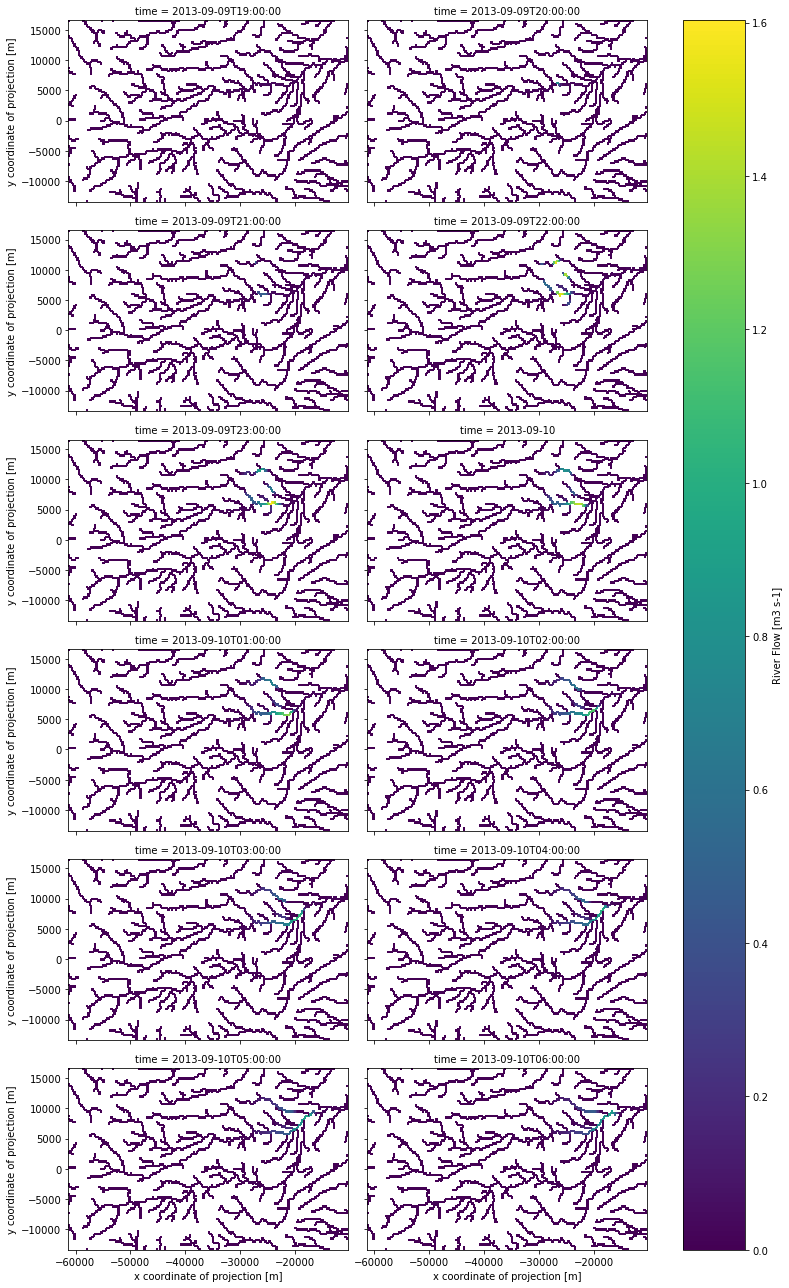

In [17]:
ds.streamflow[1:].plot(col='time', col_wrap=2, vmin=0, aspect=ds.x.size/ds.y.size)
plt.show()

This concludes the lesson. 

Next visualize some of the outputs from this simulation in the [following lesson](Lesson-visualize.ipynb).

© UCAR 2020